In [1]:
import os, uuid
import skimage
import pandas as pd
from skimage import io
from sklearn.model_selection import train_test_split
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import hashlib
import pathlib
from shutil import copyfile
import glob
%matplotlib inline

In [2]:
ann = pd.read_csv("RoadMarkingDataset/dataset_annotations.txt", header=None)
## Rename columns
ssd_df = ann.rename({9: 'image_name', 8: 'class_id'}, axis=1) 

In [3]:
## Let's train a model on the images containing leftturn, rightturn, and forward
criterion = lambda row: row['class_id'] in ['leftturn','rightturn','forward']
df_arrows = ssd_df[ssd_df.apply(criterion, axis=1)]

In [4]:
df_arrows['md5'] = np.nan
df_arrows.head()

/home/dmu/anaconda3/envs/ssdkeras/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,class_id,image_name,md5
10,224.792847,305.990845,319.302002,274.044098,325.808655,330.746918,314.697540,310.993835,leftturn,roadmark_0011.png,NaN
11,215.475037,298.004150,316.639771,258.070709,330.746918,335.685181,318.401245,314.697540,leftturn,roadmark_0012.png,NaN
12,202.163895,282.030792,308.653076,248.752914,334.450623,344.327148,323.339508,318.401245,leftturn,roadmark_0013.png,NaN
13,186.190521,270.050751,304.659729,232.779541,341.858032,350.500000,328.277771,323.339508,leftturn,roadmark_0014.png,NaN
14,155.574875,252.746262,294.010803,222.130615,348.030853,360.376556,333.216034,327.043213,leftturn,roadmark_0015.png,NaN


In [5]:
for index,row in df_arrows.iterrows():
    file_path = 'RoadMarkingDataset/'+ row['image_name'].replace(".png",".jpg")
    m5 = hashlib.md5(pathlib.Path(file_path).read_bytes()).hexdigest()
    df_arrows.loc[index, 'md5'] = m5

/home/dmu/.local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
final_img = df_arrows.drop_duplicates(['md5'])
final_img['image_name'] = final_img.image_name.str.replace(".png",".jpg")
final_img.head()

/home/dmu/anaconda3/envs/ssdkeras/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,class_id,image_name,md5
10,224.792847,305.990845,319.302002,274.044098,325.808655,330.746918,314.697540,310.993835,leftturn,roadmark_0011.jpg,b35512817146d2e054db24dfabe15006
11,215.475037,298.004150,316.639771,258.070709,330.746918,335.685181,318.401245,314.697540,leftturn,roadmark_0012.jpg,857c35771fe5172118ac13579333c546
12,202.163895,282.030792,308.653076,248.752914,334.450623,344.327148,323.339508,318.401245,leftturn,roadmark_0013.jpg,8db63add5c818d4b7dfa450d982bea81
13,186.190521,270.050751,304.659729,232.779541,341.858032,350.500000,328.277771,323.339508,leftturn,roadmark_0014.jpg,947d8cb34ac191ea85ece8b217d0ffe7
14,155.574875,252.746262,294.010803,222.130615,348.030853,360.376556,333.216034,327.043213,leftturn,roadmark_0015.jpg,72a078fb1b337479eef921041db38c12


In [59]:
for img in final_img.image_name:
    src = "RoadMarkingDataset/" + img
    dst = "arrow_signs/" + img
    copyfile(src, dst)    

In [20]:
## Read annotated files
arr = []
for file in glob.glob('arrow_signs/roadmark*.txt'):
#     print(file)
    row = pd.read_csv(file, header=None, delimiter = " ")
    row['image_name'] = file.replace(".txt",".jpg")
    arr.append(row)
frame = pd.concat(arr, axis=0, ignore_index=True)
frame['image_name'] = frame['image_name'].str.replace("arrow_signs/","")
frame.columns = ['class_id','xmin1','ymin1','xmax1','ymax1','image_name']
frame.head()

,class_id,xmin1,ymin1,xmax1,ymax1,image_name
0,0,0.275000,0.517500,0.09500,0.058333,roadmark_0873.jpg
1,0,0.172500,0.551667,0.08500,0.046667,roadmark_1336.jpg
2,0,0.398125,0.543333,0.07125,0.040000,roadmark_1042.jpg
3,0,0.529375,0.627500,0.15375,0.091667,roadmark_0917.jpg
4,0,0.400000,0.545833,0.08000,0.035000,roadmark_1032.jpg


In [21]:
frame['xmin'] = round(frame['xmin1']*800 - ((frame['xmax1']*800)*0.5))
frame['ymin'] = round(frame['ymin1']*600 - ((frame['ymax1']*600)*0.5))
frame['xmax'] = round(frame['xmin1']*800 + ((frame['xmax1']*800)*0.5))
frame['ymax'] = round(frame['ymin1']*600 + ((frame['ymax1']*600)*0.5))
frame.head()

,class_id,xmin1,ymin1,xmax1,ymax1,image_name,xmin,ymin,xmax,ymax
0,0,0.275000,0.517500,0.09500,0.058333,roadmark_0873.jpg,182.0,293.0,258.0,328.0
1,0,0.172500,0.551667,0.08500,0.046667,roadmark_1336.jpg,104.0,317.0,172.0,345.0
2,0,0.398125,0.543333,0.07125,0.040000,roadmark_1042.jpg,290.0,314.0,347.0,338.0
3,0,0.529375,0.627500,0.15375,0.091667,roadmark_0917.jpg,362.0,349.0,485.0,404.0
4,0,0.400000,0.545833,0.08000,0.035000,roadmark_1032.jpg,288.0,317.0,352.0,338.0


In [22]:
ssd_format = frame[['image_name','xmin','xmax','ymin','ymax', 'class_id']]
ssd_format = ssd_format.astype({'class_id':'category','ymin':'int','ymax':'int','xmax':'int','xmin':'int'})
ssd_format = ssd_format.sort_values("image_name")
ssd_format.head()

,image_name,xmin,xmax,ymin,ymax,class_id
622,roadmark_0011.jpg,251,306,313,333,0
623,roadmark_0011.jpg,307,341,296,310,0
1184,roadmark_0012.jpg,239,299,314,338,0
1185,roadmark_0012.jpg,299,339,296,313,0
189,roadmark_0013.jpg,228,292,320,346,0


In [23]:
myimg = io.imread('arrow_signs/roadmark_0011.jpg')
batch_labels = ssd_format.query("image_name == 'roadmark_0011.jpg'")

In [24]:
batch_labels

,image_name,xmin,xmax,ymin,ymax,class_id
622,roadmark_0011.jpg,251,306,313,333,0
623,roadmark_0011.jpg,307,341,296,310,0


   class   conf xmin   ymin   xmax   ymax


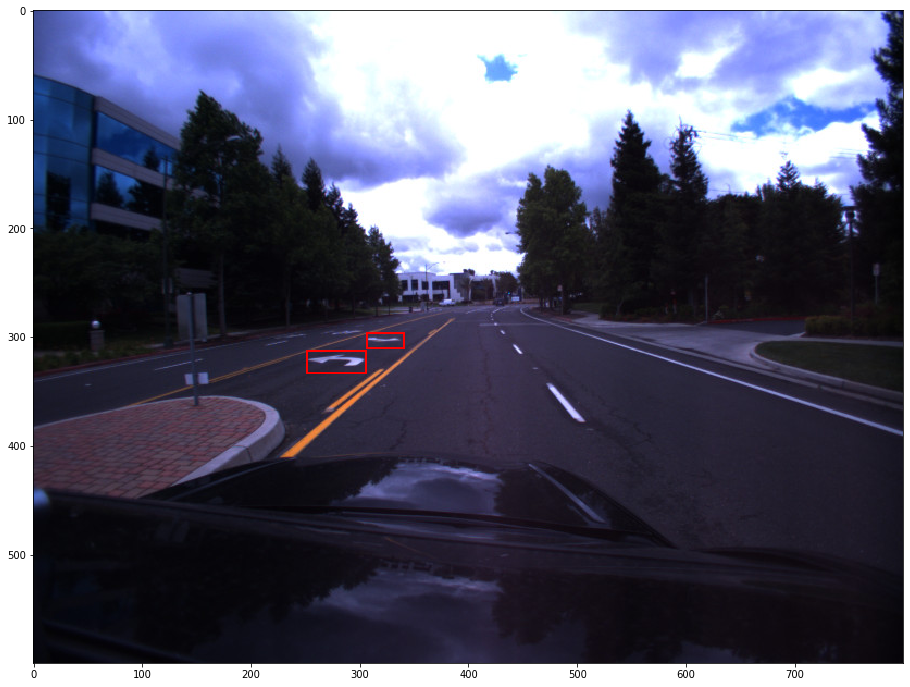

In [30]:
## Check image if boxes are printed correctly
from skimage.transform import resize

plt.figure(figsize=(20,12))
plt.imshow(myimg)

current_axis = plt.gca()
n_classes = 3
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background','leftturn','rightturn','forward'] # Just so we can print class names onto the image instead of IDs
print('   class   conf xmin   ymin   xmax   ymax')
# xmin   ymin   xmax   ymax
# Draw the ground truth boxes in green (omit the label for more clarity)
for index, box in batch_labels.iterrows():
    xmin = box[1]
    ymin = box[3]
    xmax = box[2]
    ymax = box[4]
    label = box[5]
    color = colors[int(box[5])]
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  


In [26]:
## We will resize the images to 300x400 for higher training speed, hence half the pixel positions
ssd_out = ssd_format
ssd_out['xmin'] = round(ssd_out['xmin']/2).astype(int)
ssd_out['xmax'] = round(ssd_out['xmax']/2).astype(int)
ssd_out['ymin'] = round(ssd_out['ymin']/2).astype(int)
ssd_out['ymax'] = round(ssd_out['ymax']/2).astype(int)
ssd_out['class_id'] = ssd_out['class_id'].astype(int)
ssd_out['class_id'] = ssd_out.class_id +1 ## Class 0 is reserved for background
print(ssd_out.head())

             image_name  xmin  xmax  ymin  ymax  class_id
622   roadmark_0011.jpg   126   153   156   166         1
623   roadmark_0011.jpg   154   170   148   155         1
1184  roadmark_0012.jpg   120   150   157   169         1
1185  roadmark_0012.jpg   150   170   148   156         1
189   roadmark_0013.jpg   114   146   160   173         1


In [27]:
ssd_out.to_csv("arrow_signs/wegpijlen.csv",index=None)